This notebook seeks to ascertain the effet of EHR on controlled drugs (CD). Without reviewing an EHR specfically about this issue, my theory is that this could possibly happen in two ways.
a) The EHR defaults to a particular quantity e.g. 28 v 56. THis could lead to higher quantity or possibly increased items but less quantity
b) On the medicines pick list the order of the medicines could nudge prescribers into selecting a particular preparation e.g. Pregabalin 25mg v Pregabalin 50mg. This may effect a starting dose.

In [1]:
##import libraries neededd
import pandas as pd
import numpy as np
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [2]:
## ensuring the format is consistent for pounds and pence
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Part 1 Overall CD Prescribing

In [4]:
sql = '''
SELECT
  Date,
  pct,
  presc.practice,
  TRIM(Principal_Supplier) AS supplier,
  Sum(Items) as items,
  AVG(total_list_size) AS list_size
FROM
  ebmdatalab.hscic.normalised_prescribing_standard AS presc  
JOIN
  ebmdatalab.hscic.practice_statistics AS prac
ON
  prac.practice = presc.practice AND prac.month = presc.month
JOIN
  (SELECT DISTINCT bnf_code FROM ebmdatalab.dmd.product 
  WHERE controlled_drug_category BETWEEN 1 AND 10) AS dmd ##this identifies all CD sceduled medicines
ON
  presc.bnf_code = dmd.bnf_code
JOIN
  ebmdatalab.alex.vendors AS software #this is where the up to date vendors table is held
ON
  software.ODS = presc.practice
  AND Date = presc.month

WHERE total_list_size > 1000 -- exclude non-standard practices

GROUP BY
  Date,
  pct,
  presc.practice,
  supplier
'''



df_dmd_cd = bq.cached_read(sql, csv_path='amp_dmd_cd_ver6.csv', use_cache=True)
df_dmd_cd['Date'] = df_dmd_cd['Date'].astype('datetime64[ns]')
df_dmd_cd.head(10)


,Date,pct,practice,supplier,items,list_size
0,2016-02-01,11M,L84073,Unknown,588,4194.00
1,2016-01-01,02E,Y04926,Unknown,12,3337.00
2,2016-02-01,02F,N81023,Unknown,599,5049.00
3,2016-01-01,07M,E83629,Unknown,127,3367.00
4,2016-01-01,07M,E83632,Unknown,175,4058.00
5,2016-02-01,07M,E83629,Unknown,119,3367.00
6,2016-02-01,08T,H85019,Unknown,417,4990.00
7,2016-02-01,06N,E82630,Unknown,165,2452.00
8,2016-01-01,08T,H85019,Unknown,427,4990.00
9,2016-02-01,01W,P88004,Unknown,918,10655.00


In [5]:
df_dmd_cd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288261 entries, 0 to 288260
Data columns (total 6 columns):
Date         288261 non-null datetime64[ns]
pct          288261 non-null object
practice     288261 non-null object
supplier     288261 non-null object
items        288261 non-null int64
list_size    288261 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 13.2+ MB


In [6]:
df_dmd_cd.describe()

,items,list_size
count,288261.00,288261.00
mean,674.21,8086.54
std,508.27,5010.70
min,1.00,1001.00
25%,317.00,4475.00
50%,550.00,7151.00
75%,907.00,10586.00
max,12644.00,73525.00


In [7]:
df_dmd_cd["items_per_patient"] = df_dmd_cd["items"] / df_dmd_cd["list_size"]
df_dmd_cd.head(5)

,Date,pct,practice,supplier,items,list_size,items_per_patient
0,2016-02-01,11M,L84073,Unknown,588,4194.00,0.14
1,2016-01-01,02E,Y04926,Unknown,12,3337.00,0.00
2,2016-02-01,02F,N81023,Unknown,599,5049.00,0.12
3,2016-01-01,07M,E83629,Unknown,127,3367.00,0.04
4,2016-01-01,07M,E83632,Unknown,175,4058.00,0.04


In [8]:
df_dmd_cd.describe()

,items,list_size,items_per_patient
count,288261.00,288261.00,288261.00
mean,674.21,8086.54,0.09
std,508.27,5010.70,0.04
min,1.00,1001.00,0.00
25%,317.00,4475.00,0.06
50%,550.00,7151.00,0.08
75%,907.00,10586.00,0.11
max,12644.00,73525.00,0.89


In [9]:
df1 = df_dmd_cd.groupby(["Date", "supplier"]).sum().reset_index()
df1.head(5)

,Date,supplier,items,list_size,items_per_patient
0,2016-01-01,EMIS,2597577,31972631.00,356.78
1,2016-01-01,INPS,369161,4642695.00,53.25
2,2016-01-01,Microtest,79380,697082.00,12.09
3,2016-01-01,TPP,1775837,20073721.00,231.92
4,2016-01-01,Unknown,7276,93806.00,1.52


In [10]:
df1["actual_items_per_patient"] = df1["items"] / df1["list_size"]
df1.head(5)

,Date,supplier,items,list_size,items_per_patient,actual_items_per_patient
0,2016-01-01,EMIS,2597577,31972631.00,356.78,0.08
1,2016-01-01,INPS,369161,4642695.00,53.25,0.08
2,2016-01-01,Microtest,79380,697082.00,12.09,0.11
3,2016-01-01,TPP,1775837,20073721.00,231.92,0.09
4,2016-01-01,Unknown,7276,93806.00,1.52,0.08


C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


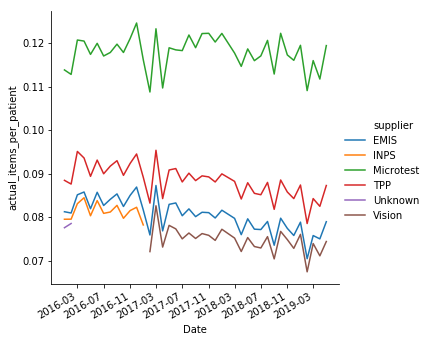

In [11]:
    sns.relplot(x="Date", y="actual_items_per_patient", hue='supplier', kind="line", data=df1)
    fig = plt.gcf()
    fig.autofmt_xdate()
    plt.show()

#### 50:50 EMIS/TPP
Let us look at prescribing in places where there is an aproximate 50:50 split in EHR

In [12]:
single_month = df_dmd_cd[df_dmd_cd['Date'] == "2019-05-01"]

In [13]:
by_pct_and_supplier = single_month.groupby(['pct', 'supplier']).count().reset_index()
by_pct = single_month.groupby(['pct']).count().reset_index()

In [14]:
# Create a list of CCGs in which between them TPP and EMIS roughly equally dominate the market
both = by_pct_and_supplier.merge(by_pct, how='inner', left_on='pct', right_on='pct')
both['proportion'] = both['practice_x'] / both['practice_y']
proportions = both[['pct', 'supplier_x', 'proportion']]
interesting_pcts = []
for key, rows in proportions.groupby('pct'):
    emis = tpp = None
    for i, row in rows.iterrows():
        if row['supplier_x'] == 'EMIS':
            emis = row['proportion']
        elif row['supplier_x'] == 'TPP':
            tpp = row['proportion']
    if emis is not None and tpp is not None:
        if emis > 0.4 and tpp > 0.4 and abs(emis - tpp) > 0.06:
            interesting_pcts.append(key)

In [15]:
qwe = pd.DataFrame(interesting_pcts)
qwe['interesting'] = 100
qwe.columns = ['pct', 'interesting']

C:\Users\bmackenna\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
C:\Users\bmackenna\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


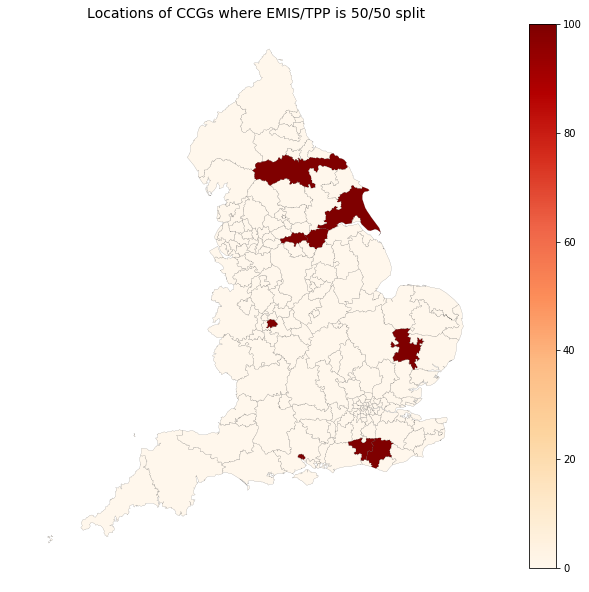

In [16]:
plt.figure(figsize=(16,10))
qwe = pd.concat([qwe, pd.DataFrame([{'pct': '08H', 'interesting': 0}])])
maps.ccg_map(
        qwe, 
        column='interesting', 
        title='Locations of CCGs where EMIS/TPP is 50/50 split',
        )
plt.show()

C:\Users\bmackenna\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


KeyError: 'percentile'

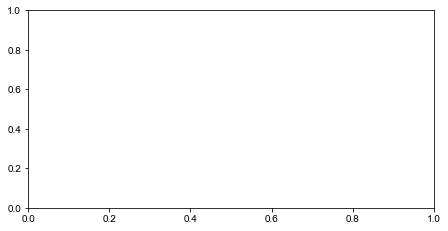

In [17]:
# Plot them side-by-side CCG
for ccg in interesting_pcts:
    plt.figure(figsize=(16,8))
    layout = gridspec.GridSpec(2, 2)
    left_plot = plt.subplot(layout[0])
    plt.setp(left_plot.get_yticklabels(), visible=True)
    for cell, supplier in enumerate(['SystmOne', 'EMIS']):
        data = df_dmd_cd[(df_dmd_cd['supplier'] == supplier) & (df_dmd_cd['pct'] == ccg)]
        plt.ylim(0,1.0)
        charts.deciles_chart(
            data,
            period_column='Date',
            column='items_per_patient',
            title="CDs {} ({}, n={})".format(ccg, supplier, data.practice.nunique()),
            ylabel="y label",
                         show_legend=False,
            
            ax=plt.subplot(layout[cell])
        )
    
    plt.show()

In [ ]:
##plot aggregate of all interesting CCGs
plt.figure(figsize=(16,8))
layout = gridspec.GridSpec(2, 2)
left_plot = plt.subplot(layout[0])
plt.setp(left_plot.get_yticklabels(), visible=True)
for cell, supplier in enumerate(['SystmOne', 'EMIS']):
    data = df_dmd_cd[(df_dmd_cd['supplier'] == supplier) & (df_dmd_cd['pct'].isin(interesting_pcts))]
    plt.ylim(0,1.0)
    charts.deciles_chart(
        data,
        period_column='Date',
        column='items_per_patient',
        title="CDs EHR = {}, practice n={} ".format(supplier, data.practice.nunique()),
        ylabel="proportion",
                    show_legend=False,

        ax=plt.subplot(layout[cell])
    )

plt.show()

## Part 2: OpenPrescribing Measures

As per the DataLab [paper on opioids](https://www.sciencedirect.com/science/article/pii/S2215036618304711) we should probably focus on measures where an adjustment has been made for tota qunatity.

Releavnt Measures
- https://openprescribing.net/measure/bdzper1000/
- https://openprescribing.net/measure/bdzadq/
- https://openprescribing.net/measure/opioidspercent/
- https://openprescribing.net/measure/opioidper1000/
- https://openprescribing.net/measure/lpfentanylir/
- https://openprescribing.net/measure/lpoxycodone/
- https://openprescribing.net/measure/gabapentinoidsddd/
- https://openprescribing.net/measure/opioidome/
- https://openprescribing.net/measure/pregabalin/
- https://openprescribing.net/measure/pregabalinmg/
    
    
    

In [ ]:
import importlib
importlib.reload(bq)
cdmeasures = ['pregabalin', 'bdzadq', 'opioidspercent', 'opioidome', 'pregabalinmg', 'opioidper1000', 'bdzper1000', 'lpfentanylir'
, 'lpoxycodone', 'gabapentinoidsddd']

def get_data(measure_id):
    sql = """
SELECT
  TRIM(Principal_Supplier) AS supplier,
  m.month,
  AVG(IEEE_DIVIDE(numerator, denominator)) AS calc_value,
  '{measure_id}' AS measure_id
FROM
  measures.practice_data_{measure_id} AS m
JOIN
  ebmdatalab.alex.vendors AS software #this is where the up to date vendors table is held
ON
  software.ODS = practice_id
  AND DATE(Date) = m.month
JOIN
  hscic.practices
ON
  practices.code = software.ODS
JOIN
  hscic.practice_statistics
ON
  practice_statistics.practice = practices.code
  AND Date = practice_statistics.month
WHERE
  practices.setting = 4
  AND total_list_size > 100
  AND denominator > 0
GROUP BY
  supplier,
  measure_id,
  m.month
ORDER BY
  m.month""".format(measure_id=measure_id)
    import pandas as pd
    df = bq.cached_read(sql, csv_path="cd_measures.csv".format(measure_id))
    return df


def get_dataframe(cdmeasures):
    df = pd.DataFrame()
    for measure in cdmeasures:
        df = df.append(get_data(measure))
    return df
df = get_dataframe(cdmeasures)

In [ ]:
# Clean up the input data
import datetime
#df = df.loc[df['month'] > '2016-02-01']  # there is some dirty data ("Unknowns") before this
df = df[(df['supplier'] == 'EMIS') | (df['supplier'] == 'TPP')]
df.month = pd.to_datetime(df['month'])
df = df[df['month'] > '2016-02-01']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
for measure in cdmeasures:
    fig, ax = plt.subplots()
    df2 = df[df['measure_id'] == measure]
    for key, grp in df2.groupby(['supplier']):
        ax = grp.plot(ax=ax, kind='line', x='month', y='calc_value', label=key)
    fig.suptitle(measure)
    plt.legend(loc='best')
    plt.show()

As Seb investigated before, there appears to be enough difference to continue wth this investigation

In [ ]:
import seaborn as sns
cdmeasuresb = ['pregabalin', 'bdzadq', 'opioidspercent', 'opioidome', 'pregabalinmg', 'opioidper1000', 'bdzper1000', 'lpfentanylir'
, 'lpoxycodone', 'gabapentinoidsddd']

for measure_id in cdmeasuresb:
    sql = """SELECT
  TRIM(Principal_Supplier) AS supplier,
  m.month,
  practice_id,
  IEEE_DIVIDE(numerator, denominator) AS calc_value
FROM
  measures.practice_data_{} m
JOIN
  hscic.vendors software
ON
  software.ODS = practice_id
  AND software.Date = m.month
JOIN
  hscic.practices
ON
  practices.code = software.ODS
JOIN
  hscic.practice_statistics
ON
  practice_statistics.practice = practices.code
  AND Date = DATE(practice_statistics.month)
WHERE
  practices.setting = 4
  AND total_list_size > 100 -- exclude non-standard practices
         ORDER BY
          month""".format(measure_id)
    detailed = bq.cached_read(sql, csv_path="cdball.csv".format(measure_id))
    detailed.month = pd.to_datetime(detailed['month'])

    sns.relplot(x="month", y="calc_value", hue='supplier', kind="line", data=detailed)
    fig = plt.gcf()
    fig.autofmt_xdate()
    fig.suptitle(measure_id) 
    plt.show()

Microtest clouds as a large margin for error. Lets try again on the three systems TPP, EMIS, Vision

In [ ]:
import seaborn as sns
cdmeasuresb = ['pregabalin', 'bdzadq', 'opioidspercent', 'opioidome', 'pregabalinmg', 'opioidper1000', 'bdzper1000', 'lpfentanylir'
, 'lpoxycodone', 'gabapentinoidsddd']

for measure_id in cdmeasuresb:
    sql = """SELECT
  TRIM(Principal_Supplier) AS supplier,
  m.month,
  practice_id,
  IEEE_DIVIDE(numerator, denominator) AS calc_value
FROM
  measures.practice_data_{} m
JOIN
  hscic.vendors software
ON
  software.ODS = practice_id
  AND software.Date = m.month
JOIN
  hscic.practices
ON
  practices.code = software.ODS
JOIN
  hscic.practice_statistics
ON
  practice_statistics.practice = practices.code
  AND Date = DATE(practice_statistics.month)
WHERE
  practices.setting = 4
  AND total_list_size > 100 -- exclude non-standard practices
  AND TRIM(Principal_Supplier) = 'EMIS' OR TRIM(Principal_Supplier) = 'TPP' OR TRIM(Principal_Supplier) = 'Vision'
         ORDER BY
          month""".format(measure_id)
    detailed = bq.cached_read(sql, csv_path="cdbsansmt.csv".format(measure_id))
    detailed.month = pd.to_datetime(detailed['month'])

    sns.relplot(x="month", y="calc_value", hue='supplier', kind="line", data=detailed)
    fig = plt.gcf()
    fig.autofmt_xdate()
    fig.suptitle(measure_id) 
    plt.show()

In [ ]:
import seaborn as sns
cdmeasuresb = ['pregabalin', 'bdzadq', 'opioidspercent', 'opioidome', 'pregabalinmg', 'opioidper1000', 'bdzper1000', 'lpfentanylir'
, 'lpoxycodone', 'gabapentinoidsddd']

for measure_id in cdmeasuresb:
    sql = """SELECT
  TRIM(Principal_Supplier) AS supplier,
  m.month,
  practice_id,
  IEEE_DIVIDE(numerator, denominator) AS calc_value
FROM
  measures.practice_data_{} m
JOIN
  hscic.vendors software
ON
  software.ODS = practice_id
  AND software.Date = m.month
JOIN
  hscic.practices
ON
  practices.code = software.ODS
JOIN
  hscic.practice_statistics
ON
  practice_statistics.practice = practices.code
  AND Date = DATE(practice_statistics.month)
WHERE
  practices.setting = 4
  AND total_list_size > 100 -- exclude non-standard practices
  AND TRIM(Principal_Supplier) = 'EMIS' OR TRIM(Principal_Supplier) = 'TPP'
         ORDER BY
          month""".format(measure_id)
    detailed = bq.cached_read(sql, csv_path="cdbemistpp.csv".format(measure_id))
    detailed.month = pd.to_datetime(detailed['month'])

    sns.relplot(x="month", y="calc_value", hue='supplier', kind="line", data=detailed)
    fig = plt.gcf()
    fig.autofmt_xdate()
    fig.suptitle(measure_id) 
    plt.show()

working theory is that when it is an items differnce issue the EHR defaults to a different qty e.g. 28 v 56
when it has been adjusted for qty working thery is that the system presnets a higher stregth product further up the picking list